# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from DDPG_Agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from unityagents import UnityEnvironment
#For keeping long sessions alive
import workspace_utils
%matplotlib inline

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.10599999763071537


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
# DDPG Deep Deterministic Policy Gradient function 

def ddpg(n_episodes=500, max_t=1000, goal_score=30.0, block_episodes=100, print_every=10, train_mode=True):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes        : maximum number of training episodes
        max_t             : maximum number of timesteps per episode
        train_mode        : if 'True' set environment to training mode
        goal_score        : goal of the project
        block_episodes    : number of  episodes used to calculate score
        print_every       : interval to display results

    """
    mean_scores = []                               # mean scores from each episode
    min_scores = []                                # lowest scores from each episode
    max_scores = []                                # highest scores from each episode
    best_score = -np.inf                           # best score
    scores_window = deque(maxlen=block_episodes)  # mean scores from most recent episodes
    movs_avgs = []                                 # list of movements averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
        states = env_info.vector_observations                   # get the current state of agents      
        scores = np.zeros(num_agents)                           # initialize scores for agents
        agent.reset()
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select the action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get the next state
            rewards = env_info.rewards                          # get the reward
            dones = env_info.local_done                         # check if the episode is done
            
            # Reply Buffer 
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit the loop when the episode is done
                break

        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # lowest score
        max_scores.append(np.max(scores))             # highest score      
        mean_scores.append(np.mean(scores))           # episode's mean score
        scores_window.append(mean_scores[-1])         # window's mean score 
        movs_avgs.append(np.mean(scores_window))    # save movements average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} seconds)  -- \tMin: {:.1f}\tMax: {:.2f}\tMean: {:.2f}\tMov. Averege: {:.2f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], movs_avgs[-1]))
        
        if train_mode and mean_scores[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
                  
        if movs_avgs[-1] >= goal_score and i_episode >= block_episodes:
            print('\nEnvironment has been SOLVED in {} episodes!\tMoves Average ={:.2f} over last {} episodes'.format(\
                                    i_episode-block_episodes, movs_avgs[-1], block_episodes))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
                torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')  
            break
            
    return mean_scores, movs_avgs

In [7]:
from DDPG_Agent import Agent

In [8]:
# run the training loop
from workspace_utils import active_session
 
with active_session():
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
    scores, avgs = ddpg()

Episode 10 (128 seconds)  -- 	Min: 3.2	Max: 12.06	Mean: 5.85	Mov. Averege: 3.34
Episode 20 (146 seconds)  -- 	Min: 7.1	Max: 22.62	Mean: 13.18	Mov. Averege: 6.25
Episode 30 (168 seconds)  -- 	Min: 15.1	Max: 24.47	Mean: 19.42	Mov. Averege: 9.54
Episode 40 (196 seconds)  -- 	Min: 21.4	Max: 29.53	Mean: 24.78	Mov. Averege: 12.66
Episode 50 (220 seconds)  -- 	Min: 28.9	Max: 38.96	Mean: 33.67	Mov. Averege: 16.25
Episode 60 (223 seconds)  -- 	Min: 34.6	Max: 39.61	Mean: 37.60	Mov. Averege: 19.50
Episode 70 (222 seconds)  -- 	Min: 33.5	Max: 39.58	Mean: 37.87	Mov. Averege: 22.13
Episode 80 (222 seconds)  -- 	Min: 35.8	Max: 39.59	Mean: 38.65	Mov. Averege: 24.17
Episode 90 (223 seconds)  -- 	Min: 38.1	Max: 39.62	Mean: 39.21	Mov. Averege: 25.80
Episode 100 (222 seconds)  -- 	Min: 37.0	Max: 39.70	Mean: 38.92	Mov. Averege: 27.06

Environment has been SOLVED in 9 episodes!	Moves Average =30.21 over last 100 episodes


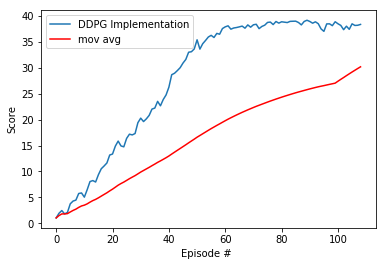

In [9]:
# Scores Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG Implementation')
plt.plot(np.arange(len(scores)), avgs, c='r', label='mov avg')
plt.ylabel('Score')
plt.xlabel('Episode # ')
plt.legend(loc='upper left');
plt.show() 

In [10]:
#When done, the env mus
env.close()